In [64]:
import pandas as pd
import string
import email
import nltk
import os
import pickle
import re
from nltk.tokenize import RegexpTokenizer
#import sklearn.cross_validation as skcv
import warnings
warnings.filterwarnings('ignore')
import sklearn.feature_extraction.text as skft
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skmetrics
import sklearn.pipeline as skpipe
import sklearn.decomposition as skd
import sklearn.naive_bayes as sknb
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import wordcloud
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

%matplotlib inline


#import email_read_util

#### Sources
- https://github.com/tianruip1994/Semantic_Analysis
- https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
- SI 370 Lecture Code (Daniel Romero)

### Collect phishing emails

In [2]:
def create_phish_df(my_dir):
    titles = []
    contents = []
    labels = []

    for f in os.listdir(os.path.join('phish',my_dir)):
            with open(os.path.join('phish', my_dir, f), 'r') as reader:
                try:
                    c = reader.read()
                except:
                    continue
                contents.append(c)
                titles.append(f)
                labels.append('phish')

    df = pd.DataFrame({'title': titles, 'content': contents, 'label': 'phish'},
                        columns = ['label', 'title', 'content'])
    return df

In [3]:
phish_email_list = ['20051114', 'phishing0', 'phishing1', 'phishing2', 'phishing3']

In [4]:
phish_lst = []
for phish_folder in phish_email_list:
    phish_lst.append(create_phish_df(phish_folder))

In [5]:
df_phish = pd.concat(phish_lst)
df_phish = df_phish[:5000]
df_phish.head()

,label,title,content
0,phish,0_False.txt,Subject: TKO Notice: ***Urgent Safeharbor Depa...
1,phish,100_False.txt,Dear eBay Member:\n\n ...
2,phish,101_False.txt,Subject: Account Security Measures\n \nSection...
3,phish,102_False.txt,Subject: =\nISO-8859-1\nb\nQmFuayBTZWN1cml0eSB...
4,phish,103_False.txt,Subject: SouthTrust Bank: Please Validate Your...


In [6]:
df_phish.shape

(4980, 3)

### Collect non-phishing emails (ham)

In [7]:
ham_email_list = ['enron3','enron4', 'enron5', 'enron6']

In [8]:
def create_ham_df(my_dir):
    titles = []
    contents = []
    labels = []

    for f in os.listdir(os.path.join(my_dir,'ham')):
            with open(os.path.join(my_dir, 'ham', f), 'r') as reader:
                try:
                    c = reader.read()
                except:
                    continue
                contents.append(c)
                titles.append(f)
                labels.append('ham')

    df = pd.DataFrame({'title': titles, 'content': contents, 'label': 'ham'},
                        columns = ['label', 'title', 'content'])
    return df
    
    

In [9]:
ham_list = []
for ham in ham_email_list:
    ham_list.append(create_ham_df(ham))

In [10]:
df_ham = pd.concat(ham_list)
df_ham = df_ham[:5000]

In [11]:
df_ham.head()

,label,title,content
0,ham,0001.2001-02-07.kitchen.ham.txt,Subject: key hr issues going forward\na ) year...
1,ham,0003.2001-02-08.kitchen.ham.txt,Subject: re : key hr issues going forward\nall...
2,ham,0005.2001-02-08.kitchen.ham.txt,Subject: epmi files protest of entergy transco...
3,ham,0006.2001-02-08.kitchen.ham.txt,Subject: california power 2 / 8\nplease contac...
4,ham,0007.2001-02-09.kitchen.ham.txt,Subject: california power 2 / 9\nthe following...


In [12]:
df_ham.shape

(5000, 3)

In [13]:
df_emails = pd.concat([df_ham, df_phish])
df_emails.sample(10)

,label,title,content
569,phish,233_True.txt,Subject: Urgent PayPal security notification N...
1218,ham,1689.2001-07-20.kitchen.ham.txt,Subject: fw : 04 counterparties\nkevin ' s awa...
3080,ham,4236.2001-11-26.kitchen.ham.txt,Subject: 8 : 30 am trade counts\noff to a weak...
1286,phish,881_False.txt,Subject: You have successfully added a new ema...
91,phish,182_False.txt,Subject: PayPal Flagged Account Dear PayPal Me...
2209,ham,3034.2001-10-10.kitchen.ham.txt,Subject: western power update 10 / 10 / 2001\n...
977,ham,3920.2001-12-30.williams.ham.txt,Subject: start date : 12 / 30 / 01 ; hourahead...
2841,ham,3898.2001-11-11.kitchen.ham.txt,Subject: re : communication materials for you\...
3144,ham,4324.2001-11-29.kitchen.ham.txt,Subject: good question ( s )\ni can answer som...
721,phish,370_False.txt,Subject: Flagged Account PayPal February 2006 ...


In [14]:
def contains_phish_link(df):
    #match = re.match(r'True', str(df.title))
    if(re.match(r'.*True.txt$', str(df.title))):
        return True
    return False

In [15]:
df_emails['malic'] = df_emails.apply(contains_phish_link, axis = 1)

In [16]:
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,Subject: key hr issues going forward\na ) year...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,Subject: re : key hr issues going forward\nall...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,Subject: epmi files protest of entergy transco...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,Subject: california power 2 / 8\nplease contac...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,Subject: california power 2 / 9\nthe following...,False


In [17]:
len(df_emails[df_emails['malic'] == True])

317

In [18]:
df_emails_train, df_emails_test = train_test_split(df_emails, test_size=0.3, random_state=0)

In [19]:
#frequency distribution
text_all = '\n'.join(df_emails_train.content).lower()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')#nltk.tokenize.wordpunct_tokenize(text_all)
tokens_all = tokenizer.tokenize(text_all)
tokens_all = [word for word in tokens_all if word not in stop_words and word != 'font' and word != 'subject']#word not in string.punctuation

In [20]:
fd = nltk.probability.FreqDist(tokens_all)

In [21]:
#fd plot for phishing emails

In [22]:
#frequency distribution
phish_text_all = '\n'.join(df_phish.content).lower()
phish_tokens_all = tokenizer.tokenize(phish_text_all)
phish_tokens_all = [word for word in phish_tokens_all if word not in stop_words and word != 'font' and word != 'subject']

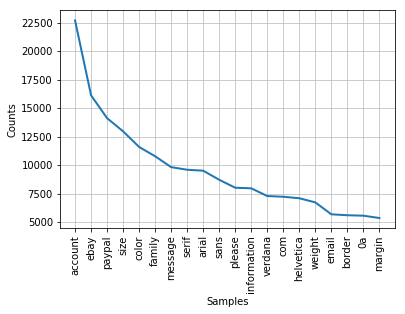

In [23]:
fd_phish = nltk.probability.FreqDist(phish_tokens_all)
fd_phish.plot(20)

In [24]:
#Create wordcloud
# wc = wordcloud.WordCloud(max_words=1000, stopwords=stop_words,
#                          margin=10,random_state=2).generate(' '.join(phish_tokens_all))

# fig,ax = plt.subplots(figsize=(12,8))
# ax.imshow(wc) #Display an image on the axes.

In [25]:
print('training set tokens', len(tokens_all))

training set tokens 1599353


In [26]:
print ('unique training set tokens', len(set(tokens_all)))

unique training set tokens 69115


### Netcraft Code

In [27]:
def netcraft_algo(df):
    if(df['malic'] == True):
        return 'phish'
    else:
        pass

In [28]:
def netcraft_cv(df, model):
    precision_scores_weighted = []
    precision_scores_micro = []
    precision_scores_macro = []
    
    precision_scores = []
    recall_scores = []
    
    f1_scores_macro = []
    f1_scores_micro = []
    f1_scores_weighted = []
    
    recall_scores_macro = []
    recall_scores_micro = []
    recall_scores_weighted = []
    
    
    accuracy_scores = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
    fold = 0
    for train_ind, test_ind in kf.split(df):

        df_emails_train = df.iloc[train_ind]
        df_emails_test =  df.iloc[test_ind]
        
        model.fit(df_emails_train.content, df_emails_train.label)
        model_test_predicted = model.predict(df_emails_test.content)

        df_emails_test['predicted_label'] = df_emails_test.apply(netcraft_algo, axis = 1)
        netcraft_test_predicted = [x for x in df_emails_test['predicted_label']]
        test_predicted = []
        for a, b in zip(netcraft_test_predicted, model_test_predicted):
            if((a == 'phish') and (b != 'phish')):
                test_predicted.append(a)
            else:
                test_predicted.append(b)
        print('fold', fold)
        print (skmetrics.classification_report(df_emails_test.label, test_predicted))
        accuracy_scores.append(skmetrics.accuracy_score(df_emails_test.label, test_predicted))
        
        f1_scores_macro.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'macro'))
        f1_scores_micro.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'micro'))
        f1_scores_weighted.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        precision_scores.append(skmetrics.precision_score(df_emails_test.label, test_predicted, pos_label = 'phish'))
        
        precision_scores_macro.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'macro'))
        precision_scores_micro.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'micro'))
        precision_scores_weighted.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        recall_scores.append(skmetrics.recall_score(df_emails_test.label, test_predicted, pos_label = 'phish'))
        
        recall_scores_macro.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'macro'))
        recall_scores_micro.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'micro'))
        recall_scores_weighted.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        
        fold += 1
    
    print('F1 Micro:', np.mean(f1_scores_micro))
    print('F1 Macro:', np.mean(f1_scores_macro))
    print('F1 Weighted:', np.mean(f1_scores_weighted))
    print()
    print('Precision Micro:', np.mean(precision_scores_micro))
    print('Precision Macro:', np.mean(precision_scores_macro))
    print('Preicision Weighted:', np.mean(precision_scores_weighted))
    print()
    print('Recall Micro:', np.mean(recall_scores_micro))
    print('Recall Macro:', np.mean(recall_scores_macro))
    print('Recall Weighted:', np.mean(recall_scores_weighted))
    print()
    print('avg accuracy:', round(np.mean(accuracy_scores), 2))
    print('avg phish precision:', round(np.mean(precision_scores), 2))
    print('avg phish recall:', round(np.mean(recall_scores), 2))

### Baseline : Random Forest

In [29]:
rf_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', RandomForestClassifier(max_depth=5, n_estimators=100))])


rf_pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [30]:
test_predicted = rf_pipeline.predict(df_emails_test.content)

In [31]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))

             precision    recall  f1-score   support

        ham       0.84      1.00      0.92      1485
      phish       1.00      0.82      0.90      1509

avg / total       0.92      0.91      0.91      2994



In [32]:
print ('Accuracy:', skmetrics.accuracy_score(df_emails_test.label, test_predicted))

Accuracy: 0.908817635270541


In [33]:
kfold = KFold(n_splits=5, random_state=0, shuffle = True)

In [34]:
rf_scores = cross_val_predict(rf_pipeline, df_emails.content, df_emails.label, cv=kfold)

In [35]:
print(skmetrics.classification_report(df_emails.label, rf_scores))

             precision    recall  f1-score   support

        ham       0.86      1.00      0.92      5000
      phish       1.00      0.84      0.91      4980

avg / total       0.93      0.92      0.92      9980



In [36]:
#Random Forest + Netcraft
netcraft_cv(df_emails, rf_pipeline)

fold 0
             precision    recall  f1-score   support

        ham       0.86      1.00      0.92       996
      phish       1.00      0.84      0.91      1000

avg / total       0.93      0.92      0.92      1996

fold 1
             precision    recall  f1-score   support

        ham       0.87      1.00      0.93      1010
      phish       1.00      0.85      0.92       986

avg / total       0.93      0.92      0.92      1996

fold 2
             precision    recall  f1-score   support

        ham       0.86      1.00      0.93       994
      phish       1.00      0.84      0.92      1002

avg / total       0.93      0.92      0.92      1996

fold 3
             precision    recall  f1-score   support

        ham       0.87      1.00      0.93      1001
      phish       1.00      0.85      0.92       995

avg / total       0.93      0.92      0.92      1996

fold 4
             precision    recall  f1-score   support

        ham       0.85      1.00      0.92       99

### Multinomial Naive Bayes

In [37]:
pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', sknb.MultinomialNB())])


In [38]:
df_emails_train, df_emails_test = train_test_split(df_emails, test_size=0.3, random_state=0)
pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [39]:
nb_test_predicted = pipeline.predict(df_emails_test.content)

In [40]:
df_emails_test.head()

,label,title,content,malic
601,phish,262_False.txt,Subject: eBay Member: marylou2804 SectionTitle...,False
1840,phish,625_False.txt,Subject: customer notification: details confir...,False
356,phish,1328_False.txt,Subject: Notification of Limited Account Acces...,False
1861,ham,2568.2001-09-18.kitchen.ham.txt,Subject: gtv weekly project status report\nple...,False
1509,ham,2080.2001-08-21.kitchen.ham.txt,Subject: thanks for the offsite\nthank you for...,False


In [41]:
df_emails_test['predicted_label'] = df_emails_test.apply(netcraft_algo, axis = 1)

In [42]:
df_emails_test.head()

,label,title,content,malic,predicted_label
601,phish,262_False.txt,Subject: eBay Member: marylou2804 SectionTitle...,False,None
1840,phish,625_False.txt,Subject: customer notification: details confir...,False,None
356,phish,1328_False.txt,Subject: Notification of Limited Account Acces...,False,None
1861,ham,2568.2001-09-18.kitchen.ham.txt,Subject: gtv weekly project status report\nple...,False,None
1509,ham,2080.2001-08-21.kitchen.ham.txt,Subject: thanks for the offsite\nthank you for...,False,None


In [43]:
netcraft_test_predicted = [x for x in df_emails_test['predicted_label']]

In [44]:
test_predicted = []
for a, b in zip(netcraft_test_predicted, nb_test_predicted):
    #print(a, b)
    if((a == 'phish') and (b != 'phish')):
        test_predicted.append(a)
    else:
        test_predicted.append(b)

In [45]:
df_emails_test['predicted_label'] = test_predicted

In [46]:
df_emails_test.head()

,label,title,content,malic,predicted_label
601,phish,262_False.txt,Subject: eBay Member: marylou2804 SectionTitle...,False,phish
1840,phish,625_False.txt,Subject: customer notification: details confir...,False,phish
356,phish,1328_False.txt,Subject: Notification of Limited Account Acces...,False,phish
1861,ham,2568.2001-09-18.kitchen.ham.txt,Subject: gtv weekly project status report\nple...,False,ham
1509,ham,2080.2001-08-21.kitchen.ham.txt,Subject: thanks for the offsite\nthank you for...,False,ham


In [47]:
print ('Accuracy:', skmetrics.accuracy_score(df_emails_test.label, test_predicted))

Accuracy: 0.9609218436873748


In [48]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))

             precision    recall  f1-score   support

        ham       0.93      1.00      0.96      1485
      phish       1.00      0.92      0.96      1509

avg / total       0.96      0.96      0.96      2994



In [49]:
print(kfold)

KFold(n_splits=5, random_state=0, shuffle=True)


In [50]:
nb_scores = cross_val_predict(pipeline, df_emails.content, df_emails.label, cv=kfold)

In [51]:
#cross val without netcraft
print(skmetrics.classification_report(df_emails.label, nb_scores))

             precision    recall  f1-score   support

        ham       0.94      1.00      0.97      5000
      phish       1.00      0.94      0.97      4980

avg / total       0.97      0.97      0.97      9980



In [52]:
#MNB + Netcraft
netcraft_cv(df_emails, pipeline)

fold 0
             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       996
      phish       1.00      0.93      0.96      1000

avg / total       0.97      0.96      0.96      1996

fold 1
             precision    recall  f1-score   support

        ham       0.96      1.00      0.98      1010
      phish       1.00      0.95      0.97       986

avg / total       0.98      0.97      0.97      1996

fold 2
             precision    recall  f1-score   support

        ham       0.95      1.00      0.97       994
      phish       1.00      0.94      0.97      1002

avg / total       0.97      0.97      0.97      1996

fold 3
             precision    recall  f1-score   support

        ham       0.94      1.00      0.97      1001
      phish       1.00      0.93      0.96       995

avg / total       0.97      0.96      0.96      1996

fold 4
             precision    recall  f1-score   support

        ham       0.93      1.00      0.96       99

### Support Vector Machine

In [53]:
svm_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7, ngram_range = (1,1))),
     ('tfidf', skft.TfidfTransformer(use_idf = True)),
     ('clf', SGDClassifier())]
)

#svm_pipeline.fit(df_emails_train.content, df_emails_train.label)

In [54]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [55]:
svm_scores = cross_val_predict(svm_pipeline, df_emails.content, df_emails.label, cv=kfold)

In [56]:
print(skmetrics.classification_report(df_emails.label, svm_scores))

             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      5000
      phish       1.00      1.00      1.00      4980

avg / total       1.00      1.00      1.00      9980



In [57]:
print(skmetrics.accuracy_score(df_emails.label, svm_scores))

0.9966933867735471


In [58]:
#SVM + Netcraft
netcraft_cv(df_emails, svm_pipeline)

fold 0
             precision    recall  f1-score   support

        ham       0.99      1.00      1.00       996
      phish       1.00      0.99      1.00      1000

avg / total       1.00      1.00      1.00      1996

fold 1
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      1010
      phish       0.99      1.00      1.00       986

avg / total       1.00      1.00      1.00      1996

fold 2
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       994
      phish       1.00      1.00      1.00      1002

avg / total       1.00      1.00      1.00      1996

fold 3
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      1001
      phish       0.99      1.00      1.00       995

avg / total       1.00      1.00      1.00      1996

fold 4
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       99

### Extra: Attempting to label spam folder as phishing

In [70]:
titles = []
contents = []
labels = []

for f in os.listdir(os.path.join('enron6','spam')):
        with open(os.path.join('enron6', 'spam', f), 'r') as reader:
            try:
                c = reader.read()
            except:
                continue
            contents.append(c)
            titles.append(f)
            labels.append('ham')

df_spam = pd.DataFrame({'title': titles, 'content': contents, 'label': 'ham'},
                    columns = ['label', 'title', 'content'])

In [71]:
predictions = svm_pipeline.predict(df_spam.content)

In [72]:
df_spam['predicted_label'] = predictions

In [62]:
df_spam.head()

,label,title,content,predicted_label
0,spam,0002.2004-08-01.BG.spam.txt,"Subject: advs\ngreetings ,\ni am benedicta lin...",ham
1,spam,0003.2004-08-01.BG.spam.txt,Subject: whats new in summer ? bawled\ncarolyn...,phish
2,spam,0004.2004-08-01.BG.spam.txt,"Subject: \nh $ ello\ndea 54 r home owner ,\nwe...",ham
3,spam,0006.2004-08-01.BG.spam.txt,Subject: : ) ) you can not save the world by q...,phish
4,spam,0007.2004-08-01.BG.spam.txt,Subject: need software ? click here .\ntop qua...,phish


In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


x= list(df_spam.label)
y= list(predictions)
print(len(x))
print(len(y))
results = confusion_matrix(x,y) 
#print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(x,y))
#print ('Report : ')
print(classification_report(x,y))

4496
4496
[[1781 2715]
 [   0    0]]
Accuracy Score : 0.39612989323843417
             precision    recall  f1-score   support

        ham       1.00      0.40      0.57      4496
      phish       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57      4496

